In [1]:
import itertools
import sys, os

import numpy as np
import pandas as pd
from scipy.special import comb
from scipy import stats
import scipy.cluster.hierarchy as hac
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
sns.set(rc={'figure.figsize':(15,8)})
sns.set_context('poster')

In [2]:
%load_ext autoreload
%autoreload 2
import CCPA_lib as cp


In [3]:
sns.set_context('poster')

In [4]:
ppallete = "BuGn"
porder = ['MIT9313', 'Natl2A', 'C9B', 'MIT9312', 'MED4']
pedge = 'green'
apallete = "Oranges"
aorder = ['1A3', 'DE', 'DE1', 'ATCC', 'BS11']
aedge='orange'              

In [5]:
df = pd.read_pickle('CCPA.pkl.gz')

In [6]:
dfc = df.loc[(df.experiment.isin(['e3', 'e4','e5', 'e6'])) & (df.culture == 'Co_Culture')]

In [7]:
df3 = df.loc[(df.experiment.isin(['e3'])) & (df.culture == 'Co_Culture') & (df.ALT == 'DE1')]

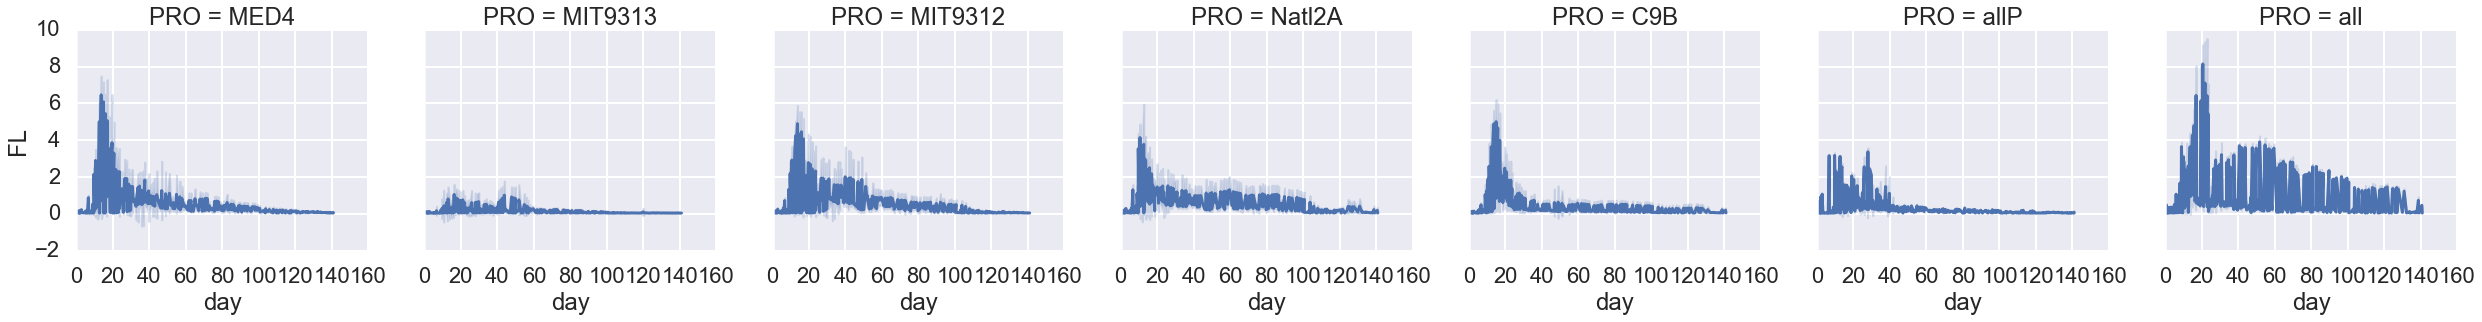

In [8]:
sns.relplot(data=df, x='day', y='FL', kind='line',  col='PRO', ci='sd')

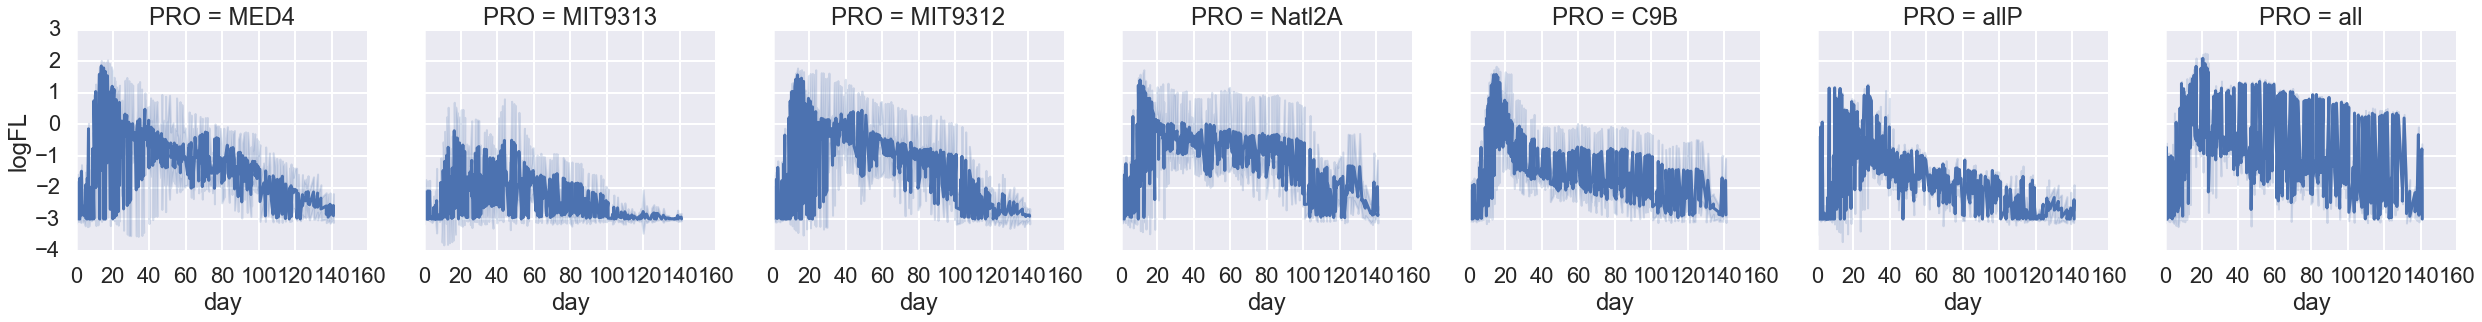

In [9]:
sns.relplot(data=df, x='day', y='logFL', kind='line',  col='PRO', ci='sd')

In [11]:
d = cp.generate_decay(df, scale=False)

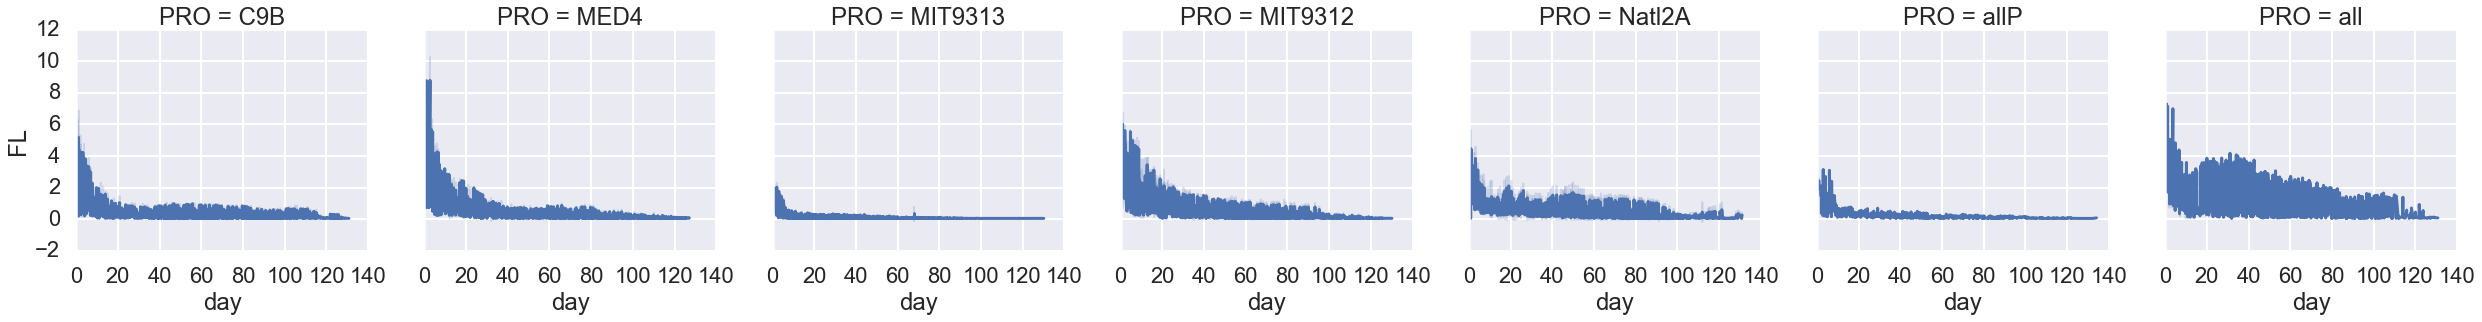

In [11]:
sns.relplot(data=d, x='day', y='FL', kind='line',  col='PRO', ci='sd')

In [8]:
def apply_fit(df, model, print_popt=False):
    x = df['day']
    y = df['FL']
    try:
        popt, pcov = curve_fit(model, x, y, method='dogbox', loss='soft_l1', f_scale=0.1, 
                              # bounds = (0, np.inf)
                              )
        y_pred = model (x, *popt)
        if print_popt:
            print(popt)

        df['y_pred'] = y_pred
        for i in range(len(popt)):
            df[f'popt_{i}'] = popt[i]
    except Exception as e:
        print(e)
        df['y_pred'] = 0

    return df


In [9]:
def apply_fit_2(df, model):
    x = df['day']
    y = df['FL']
    popt, pcov = curve_fit(model, x, y, #method='dogbox', loss='soft_l1', f_scale=0.1, 
                          # bounds = (0, np.inf)
                          )
    y_pred = model (x, *popt)
    print(popt)
    df['y_pred'] = y_pred
    return df


In [13]:
# fit all functions
functions = {'cubic' : cp.model_cubic, 
             'exponential' :cp.model_exponential,
             'exponential_segmented' : cp.model_exponential_segmented,
             'gompertz' : cp.model_gompertz,
             'harmonic' : cp.model_harmonic,
             'linear' : cp.model_linear,
             'logistic3' : cp.model_logistic3,
             'logistic4' : cp.model_logistic4,
             'loglogistic' : cp.model_loglogistic,
             'rodbard4' : cp.model_rodbard4,
             'scurve' : cp.model_scurve,
            }
dfe = d.loc[:, ['day', 'experiment_sample', 'experiment', 'PRO', 'ALT', 'sample', 'culture', 'FL']]
for n, f in functions.items():
    print(n)
    t = dfe.groupby('experiment_sample').apply(lambda x: apply_fit(x, f))
    dfe[n] = t['y_pred']


cubic
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number

C:\Users\Osnat\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of fu

C:\Users\Osnat\Anaconda3\lib\site-packages\pandas\core\groupby\groupby.py:887: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  result = concat(values, axis=self.axis)


exponential


C:\Users\Osnat\Anaconda3\lib\site-packages\scipy\optimize\_lsq\least_squares.py:214: RuntimeWarning: overflow encountered in square
  z = (f / f_scale) ** 2


Optimal parameters not found: The maximum number of function evaluations is exceeded.


C:\Users\Osnat\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
exponential_segmented
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.


C:\Users\Osnat\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
C:\Users\Osnat\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
C:\Users\Osnat\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
C:\Users\Osnat\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
C:\Users\Osnat\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
C:\Users\Osnat\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  

Optimal parameters not found: The maximum number of function evaluations is exceeded.
gompertz
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum num

C:\Users\Osnat\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of fu

C:\Users\Osnat\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
linear


C:\Users\Osnat\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


logistic3
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.


C:\Users\Osnat\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


logistic4
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum nu

C:\Users\Osnat\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of fu

Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of fu

Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of fu

D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:543: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:543: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.


C:\Users\Osnat\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of fu

C:\Users\Osnat\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of fu

C:\Users\Osnat\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.


In [15]:
dfe.head()

,day,experiment_sample,experiment,PRO,ALT,sample,culture,FL,cubic,exponential,exponential_segmented,gompertz,harmonic,linear,logistic3,logistic4,loglogistic,rodbard4
0,0.000000,"e1, 10A",e1,C9B,DE,10A,Co_Culture,5.621,1.484516,4.987762,5.621000,5.493243,5.654502,0.803957,0.991531,0.0,5.632502,5.654502
1,0.893056,"e1, 10A",e1,C9B,DE,10A,Co_Culture,4.045,1.443578,4.173756,4.045000,4.190033,3.845194,0.799364,0.980279,0.0,3.238596,3.845195
2,1.991667,"e1, 10A",e1,C9B,DE,10A,Co_Culture,2.749,1.394644,3.369078,2.770274,3.122326,2.797318,0.793713,0.966611,0.0,2.519015,2.797319
3,4.697222,"e1, 10A",e1,C9B,DE,10A,Co_Culture,2.924,1.280692,2.049893,1.936931,1.760474,1.734250,0.779797,0.933760,0.0,1.763290,1.734251
4,5.700000,"e1, 10A",e1,C9B,DE,10A,Co_Culture,2.519,1.240772,1.729102,1.709728,1.488760,1.535789,0.774639,0.921869,0.0,1.601305,1.535790


J.J. Arps (1945):

Exponential:  The decline rate a does not varies with q. 

              q = q0* e^(-a*t)

Harmonic:     The decline rate a varies linearly with q. 

              q = q0 / (1 + a * t)

Hyperbolic:   The decline rate a varies geometrically with q 

              q = q0 / (1 + d*a*t)^(1/d)
     
     
 3-­‐parameter  Logistic :
        Y(t)  =  b1   /  [1  +  b2 *exp(  b3 *t  )] 
        
4-­‐parameter  Logistic 

        Y(t)  =  b1  +  (b2   –  b1 )  /  [1  +  exp(b3 *(t  –  b4 ))] 

3-­‐parameter  Rodbard 

Y(t)  =  (1   –  b4 )/[1  +  (t/b3 ) b2 ]  +  b4 

4-­‐parameter  Rodbard 

    Y(t)  =  (b1   –  b4 )/[1  +  (t/b3 ) b2 ]  +  b4 

Gompertz 

    Y(t)  =  b1 *exp(  –  b2* exp(  –  b3 *t)) 

Log-­‐Logistic 

    Y(t)  =  b1  –  log(1  +  b2 *exp( –  b3 *t) 

First-­‐order  Decay 

    Y(t)  =  b1 *exp(  –  b2 *t)  +  b3


In [16]:
dfe.columns

Index(['day', 'experiment_sample', 'experiment', 'PRO', 'ALT', 'sample',
       'culture', 'FL', 'cubic', 'exponential', 'exponential_segmented',
       'gompertz', 'harmonic', 'linear', 'logistic3', 'logistic4',
       'loglogistic', 'rodbard4'],
      dtype='object')

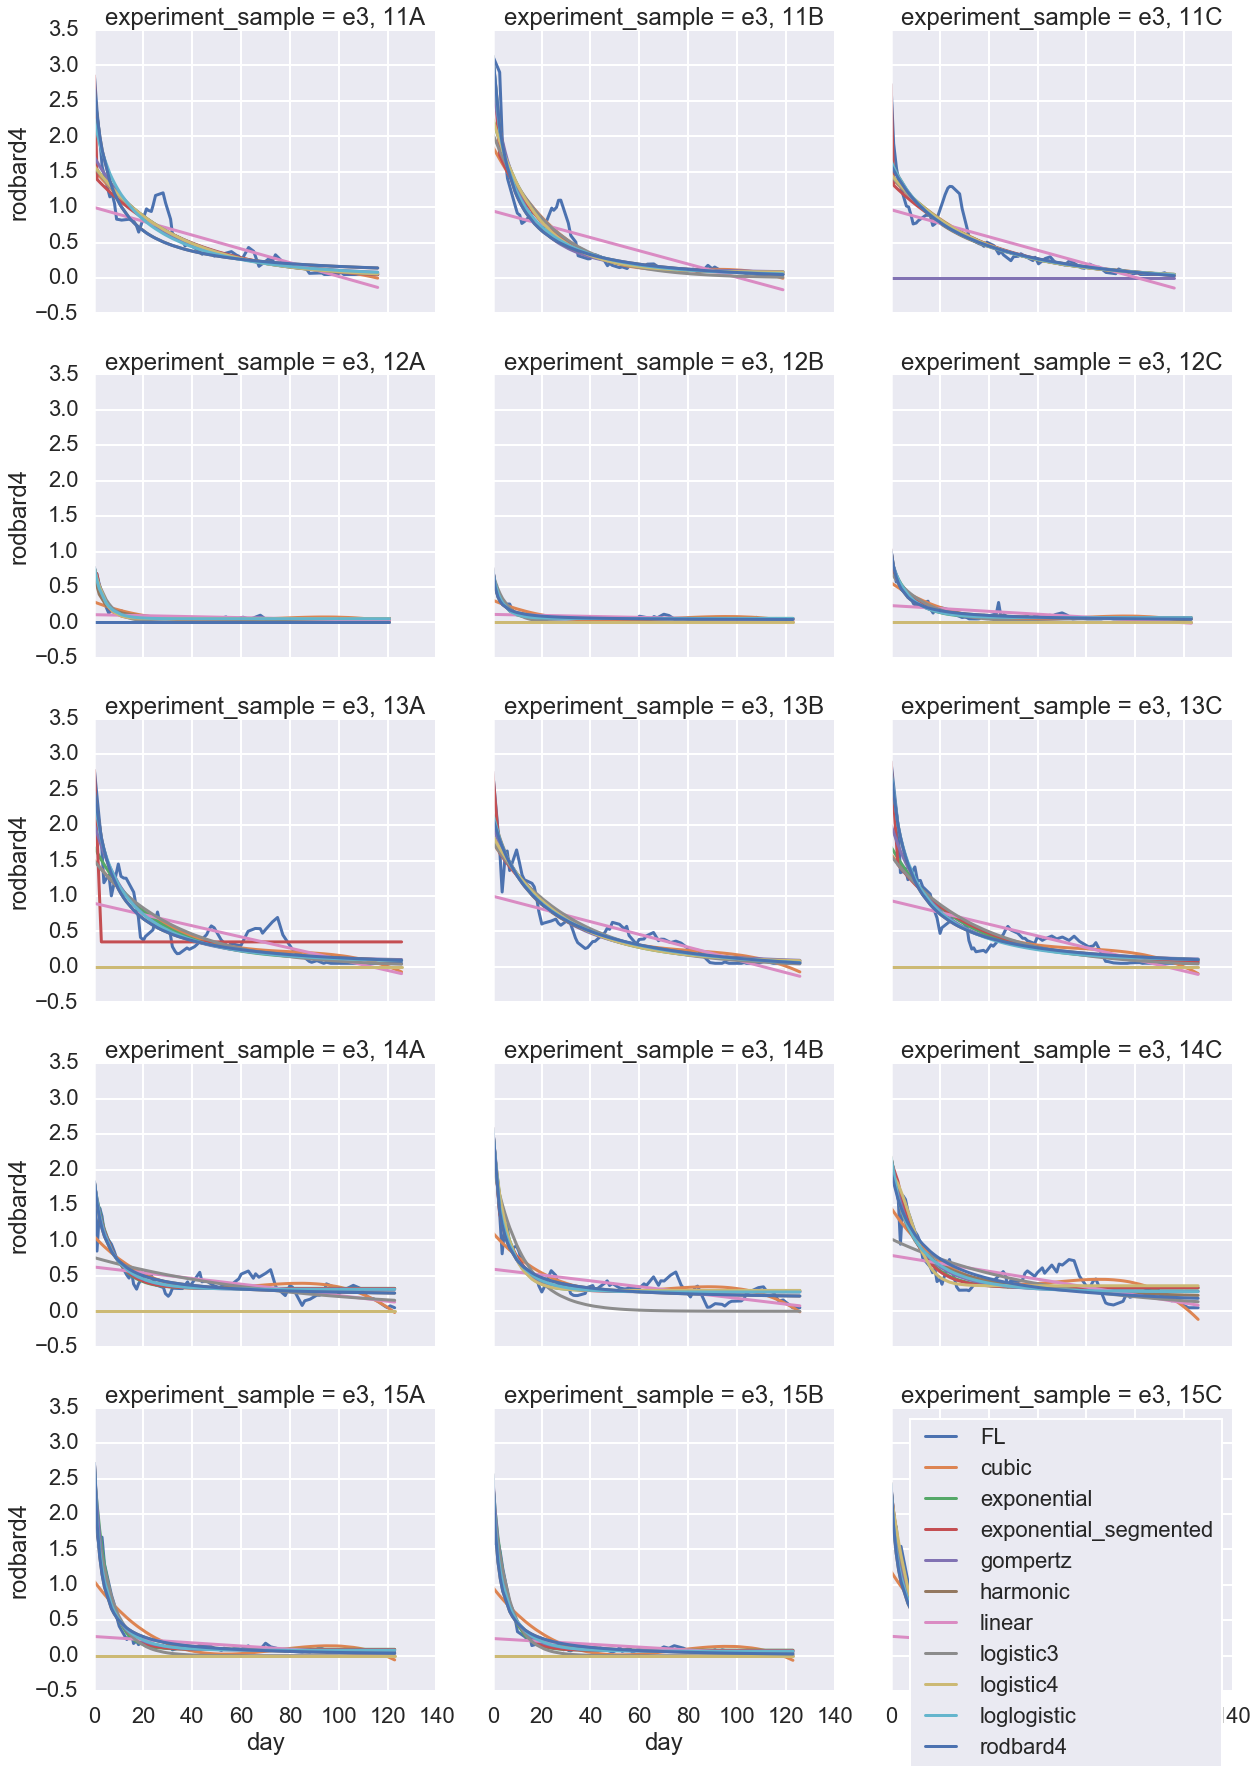

In [17]:
#for e in ['e1', 'e2', 'e3', 'e4', 'e5', 'e6', 'e7', ]:
#for e in ['e1' ]:

g = sns.FacetGrid(dfe.loc[(dfe.experiment.isin(['e3'])) & (dfe.culture == 'Co_Culture') & (dfe.ALT == 'DE1')], 
                          col = "experiment_sample", col_wrap=3, height=5, aspect=1.2 , legend_out=True)
cols =     ['FL',
     'cubic', 'exponential', 'exponential_segmented',
       'gompertz', 'harmonic', 'linear', 'logistic3', 'logistic4',
       'loglogistic', 'rodbard4', 'scurve'
           ]
colors = sns.color_palette(n_colors=len(cols), )

for i,p in zip(cols, colors):
    g.map(sns.lineplot, "day", i,  label=i, color=p)
        
plt.legend(loc='best')

In [18]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_log_error

In [19]:
def compute_score (df, y_col= 'FL', 
                   ref_cols = (
     'cubic', 'exponential', 'exponential_segmented',
       'gompertz', 'harmonic', 'linear', 'logistic3', 'logistic4',
       'loglogistic', 'rodbard4', 'scurve'),
                   meta_cols = ('PRO', 'ALT', 'sample', 'culture', 'experiment')
                  ):
    res =  {i :  r2_score(df[y_col], df[i]) for i in ref_cols}
    
    #res.update({f'{i}_log_error' :  mean_squared_log_error(df[y_col], df[i]) for i in ref_cols})
    res.update({i : df[i].unique()[0] for i in meta_cols})
    
    return pd.Series(res)
                   
ref_cols = (
     'cubic', 'exponential', 'exponential_segmented',
       'gompertz', 'harmonic', 'linear', 'logistic3', 'logistic4',
       'loglogistic', 'rodbard4', 'scurve')

scores = dfe.groupby('experiment_sample').apply(compute_score)

for i in ref_cols:
    scores.loc[scores[i] < 0,i ] = np.nan
scores


,cubic,exponential,exponential_segmented,gompertz,harmonic,linear,logistic3,logistic4,loglogistic,rodbard4,PRO,ALT,sample,culture,experiment
experiment_sample,,,,,,,,,,,,,,,
"e1, 10A",0.423485,0.930438,0.941235,0.928543,0.935724,0.149075,0.235700,NaN,0.919511,0.935724,C9B,DE,10A,Co_Culture,e1
"e1, 10B",0.390028,0.920546,0.934134,0.924637,0.937349,0.191272,0.323096,NaN,0.911715,0.937349,C9B,DE,10B,Co_Culture,e1
"e1, 10C",0.333133,0.945157,0.953811,0.946540,0.947207,0.151826,0.208935,NaN,0.907518,0.947205,C9B,DE,10C,Co_Culture,e1
"e1, 11A",0.710588,0.955676,0.955424,0.202028,0.972754,0.236990,0.909761,NaN,0.202895,0.972754,MED4,DE1,11A,Co_Culture,e1
"e1, 11B",0.652453,0.939501,0.947451,0.964118,0.978546,0.232238,0.723017,NaN,0.920654,0.978546,MED4,DE1,11B,Co_Culture,e1
"e1, 11C",0.687152,0.902080,0.934253,NaN,0.963674,0.319419,0.710399,NaN,0.927832,0.963674,MED4,DE1,11C,Co_Culture,e1
"e1, 12A",0.593085,0.928814,0.530359,0.936954,0.933649,0.306816,0.809853,NaN,0.928140,0.933649,MIT9313,DE1,12A,Co_Culture,e1
"e1, 12B",0.508744,0.900916,0.927260,0.899752,0.883335,0.240346,0.781134,0.929602,0.886741,0.883335,MIT9313,DE1,12B,Co_Culture,e1
"e1, 12C",0.527534,0.861010,0.352248,0.352248,0.837533,0.296398,0.761996,0.907579,0.352248,0.837532,MIT9313,DE1,12C,Co_Culture,e1


In [20]:
scoresm = scores.melt(id_vars=['PRO','ALT', 'sample', 'culture', 'experiment'],
           value_vars=['cubic', 'exponential', 'exponential_segmented', 'gompertz', 'harmonic',
       'linear', 'logistic3', 'logistic4', 'loglogistic', 'rodbard4', 'scurve'], 
                      var_name='method', value_name='r2score'
                     )

In [21]:
scoresm

,PRO,ALT,sample,culture,experiment,method,r2score
0,C9B,DE,10A,Co_Culture,e1,cubic,0.423485
1,C9B,DE,10B,Co_Culture,e1,cubic,0.390028
2,C9B,DE,10C,Co_Culture,e1,cubic,0.333133
3,MED4,DE1,11A,Co_Culture,e1,cubic,0.710588
4,MED4,DE1,11B,Co_Culture,e1,cubic,0.652453
5,MED4,DE1,11C,Co_Culture,e1,cubic,0.687152
6,MIT9313,DE1,12A,Co_Culture,e1,cubic,0.593085
7,MIT9313,DE1,12B,Co_Culture,e1,cubic,0.508744
8,MIT9313,DE1,12C,Co_Culture,e1,cubic,0.527534
9,MIT9312,DE1,13A,Co_Culture,e1,cubic,0.930016


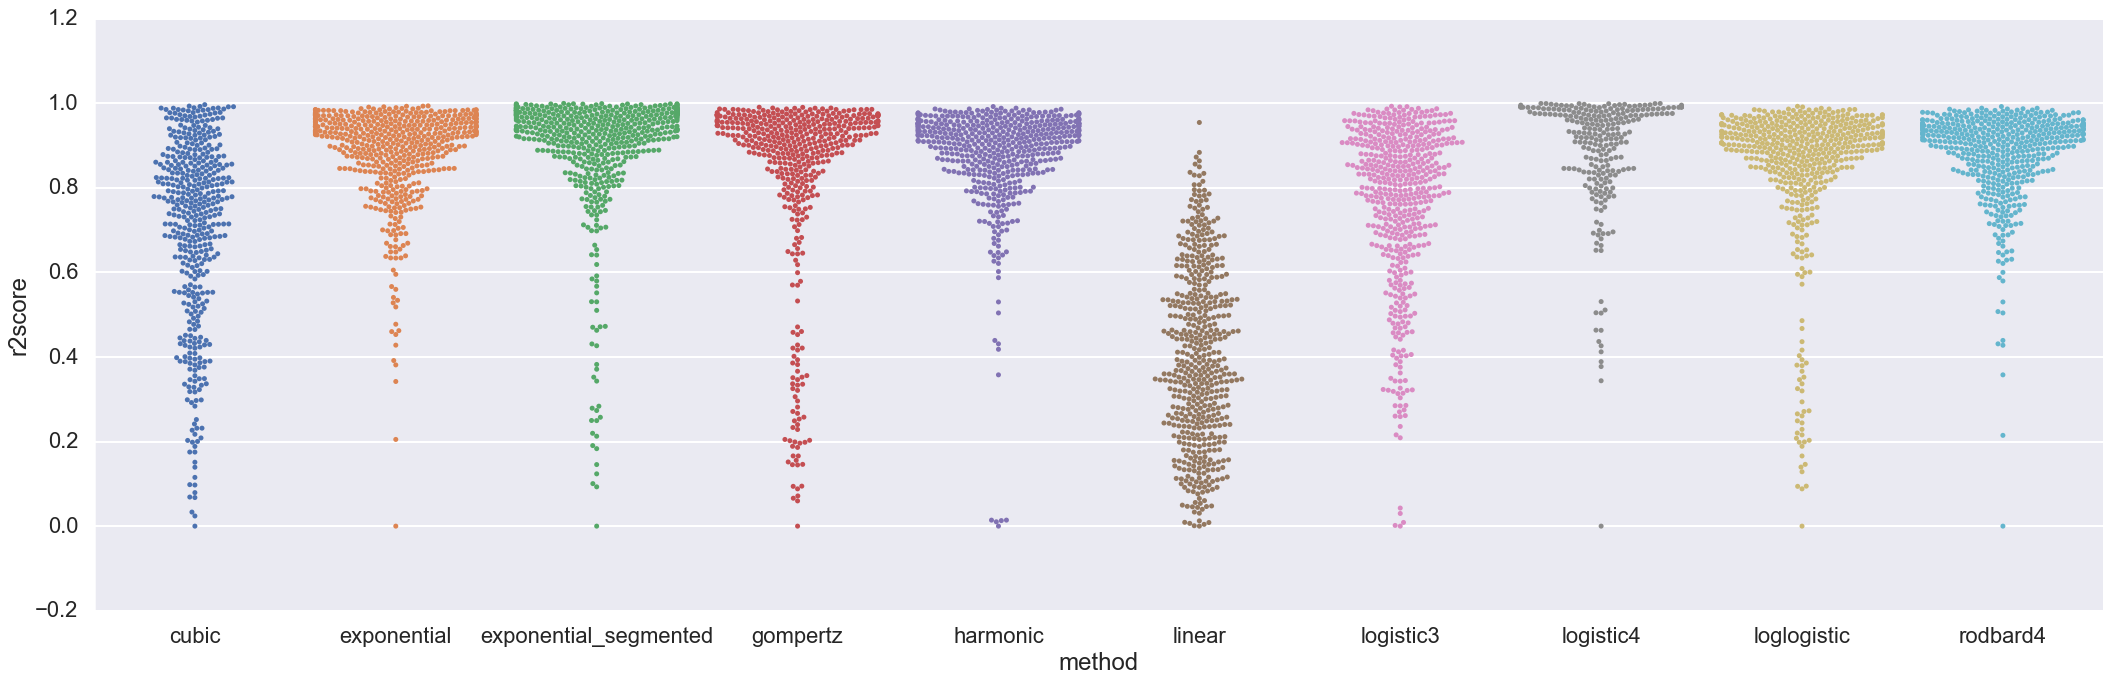

In [32]:
sns.catplot(data=scoresm, x='method', y='r2score', kind='swarm',
            #hue='PRO',
            aspect=3, height=10)
# sns.distplot(datascores.exponential, label='exponential', kde=False )
# sns.distplot(scores.linear2, label='linear', kde=False)
# sns.distplot(scores.harmonic, label='harmonic', kde=False)
# plt.legend(loc='best')

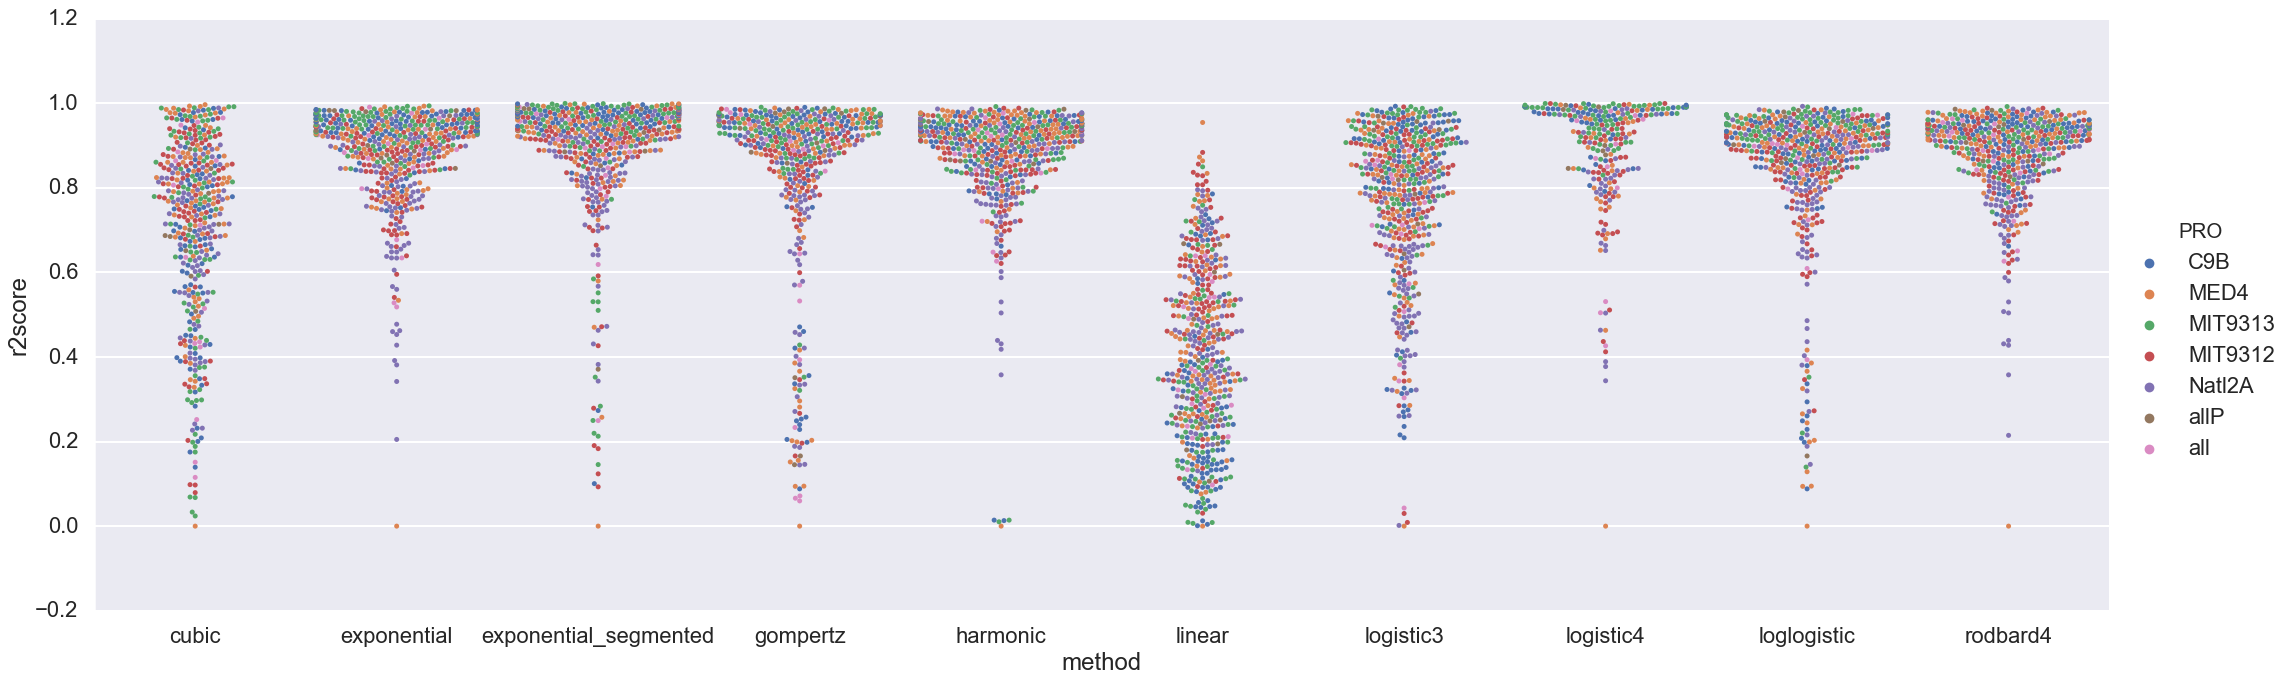

In [31]:
sns.catplot(data=scoresm, x='method', y='r2score', 
            hue='PRO', kind='swarm',
            aspect=3, height=10)
# sns.distplot(datascores.exponential, label='exponential', kde=False )
# sns.distplot(scores.linear2, label='linear', kde=False)
# sns.distplot(scores.harmonic, label='harmonic', kde=False)
# plt.legend(loc='best')

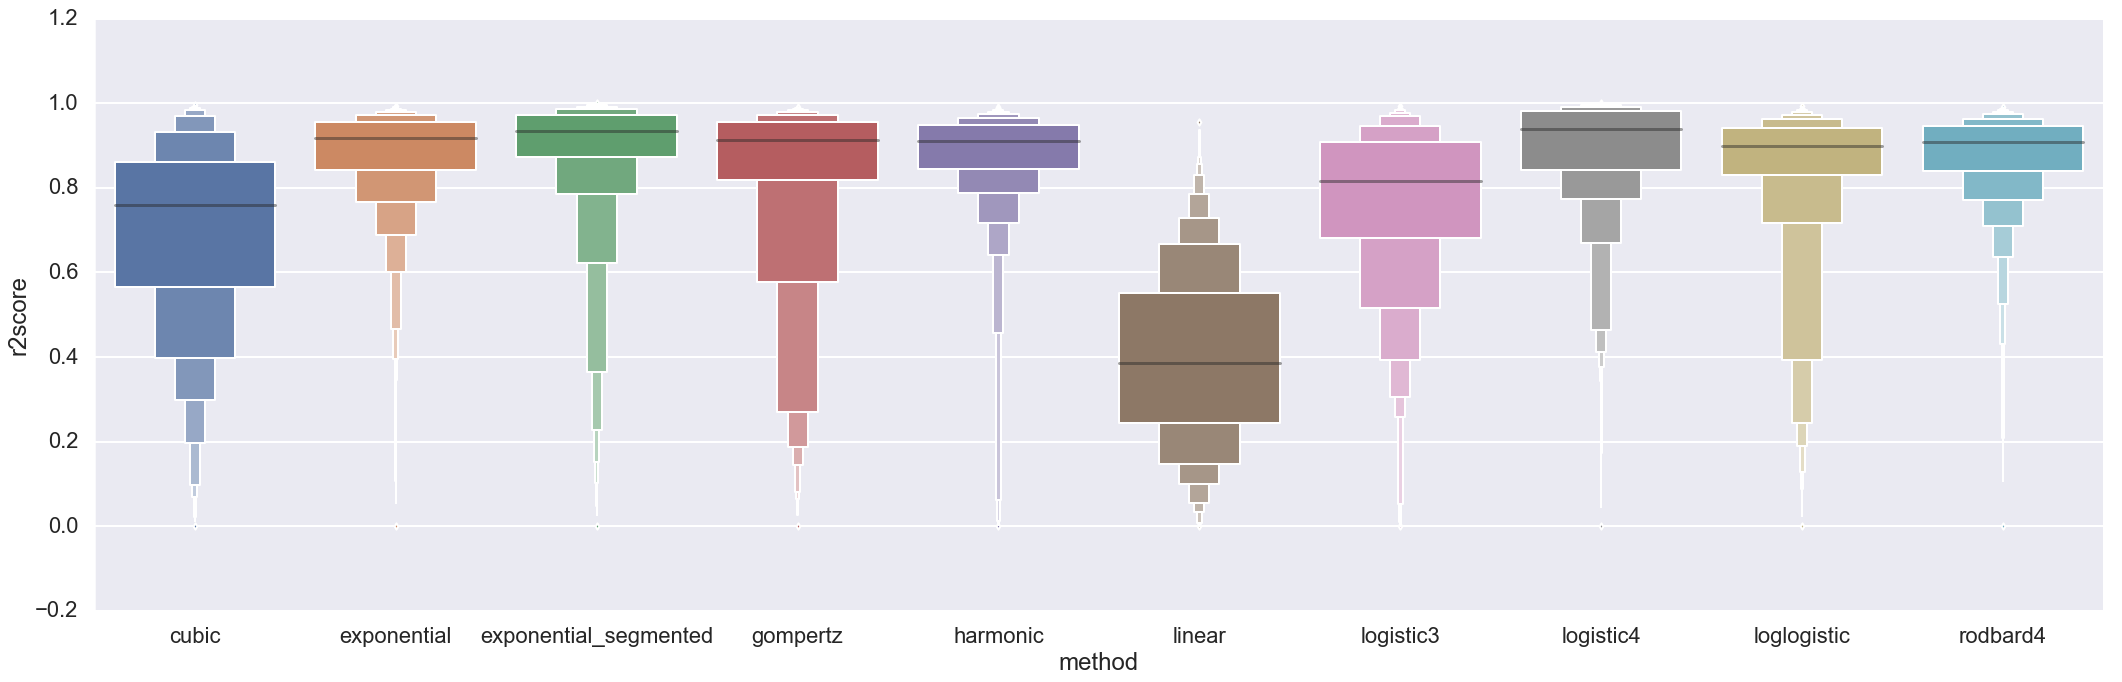

In [23]:
sns.catplot(data=scoresm, x='method', y='r2score', 
            #hue='PRO',
            kind='boxen',
            aspect=3, height=10)
# sns.distplot(datascores.exponential, label='exponential', kde=False )
# sns.distplot(scores.linear2, label='linear', kde=False)
# sns.distplot(scores.harmonic, label='harmonic', kde=False)
# plt.legend(loc='best')

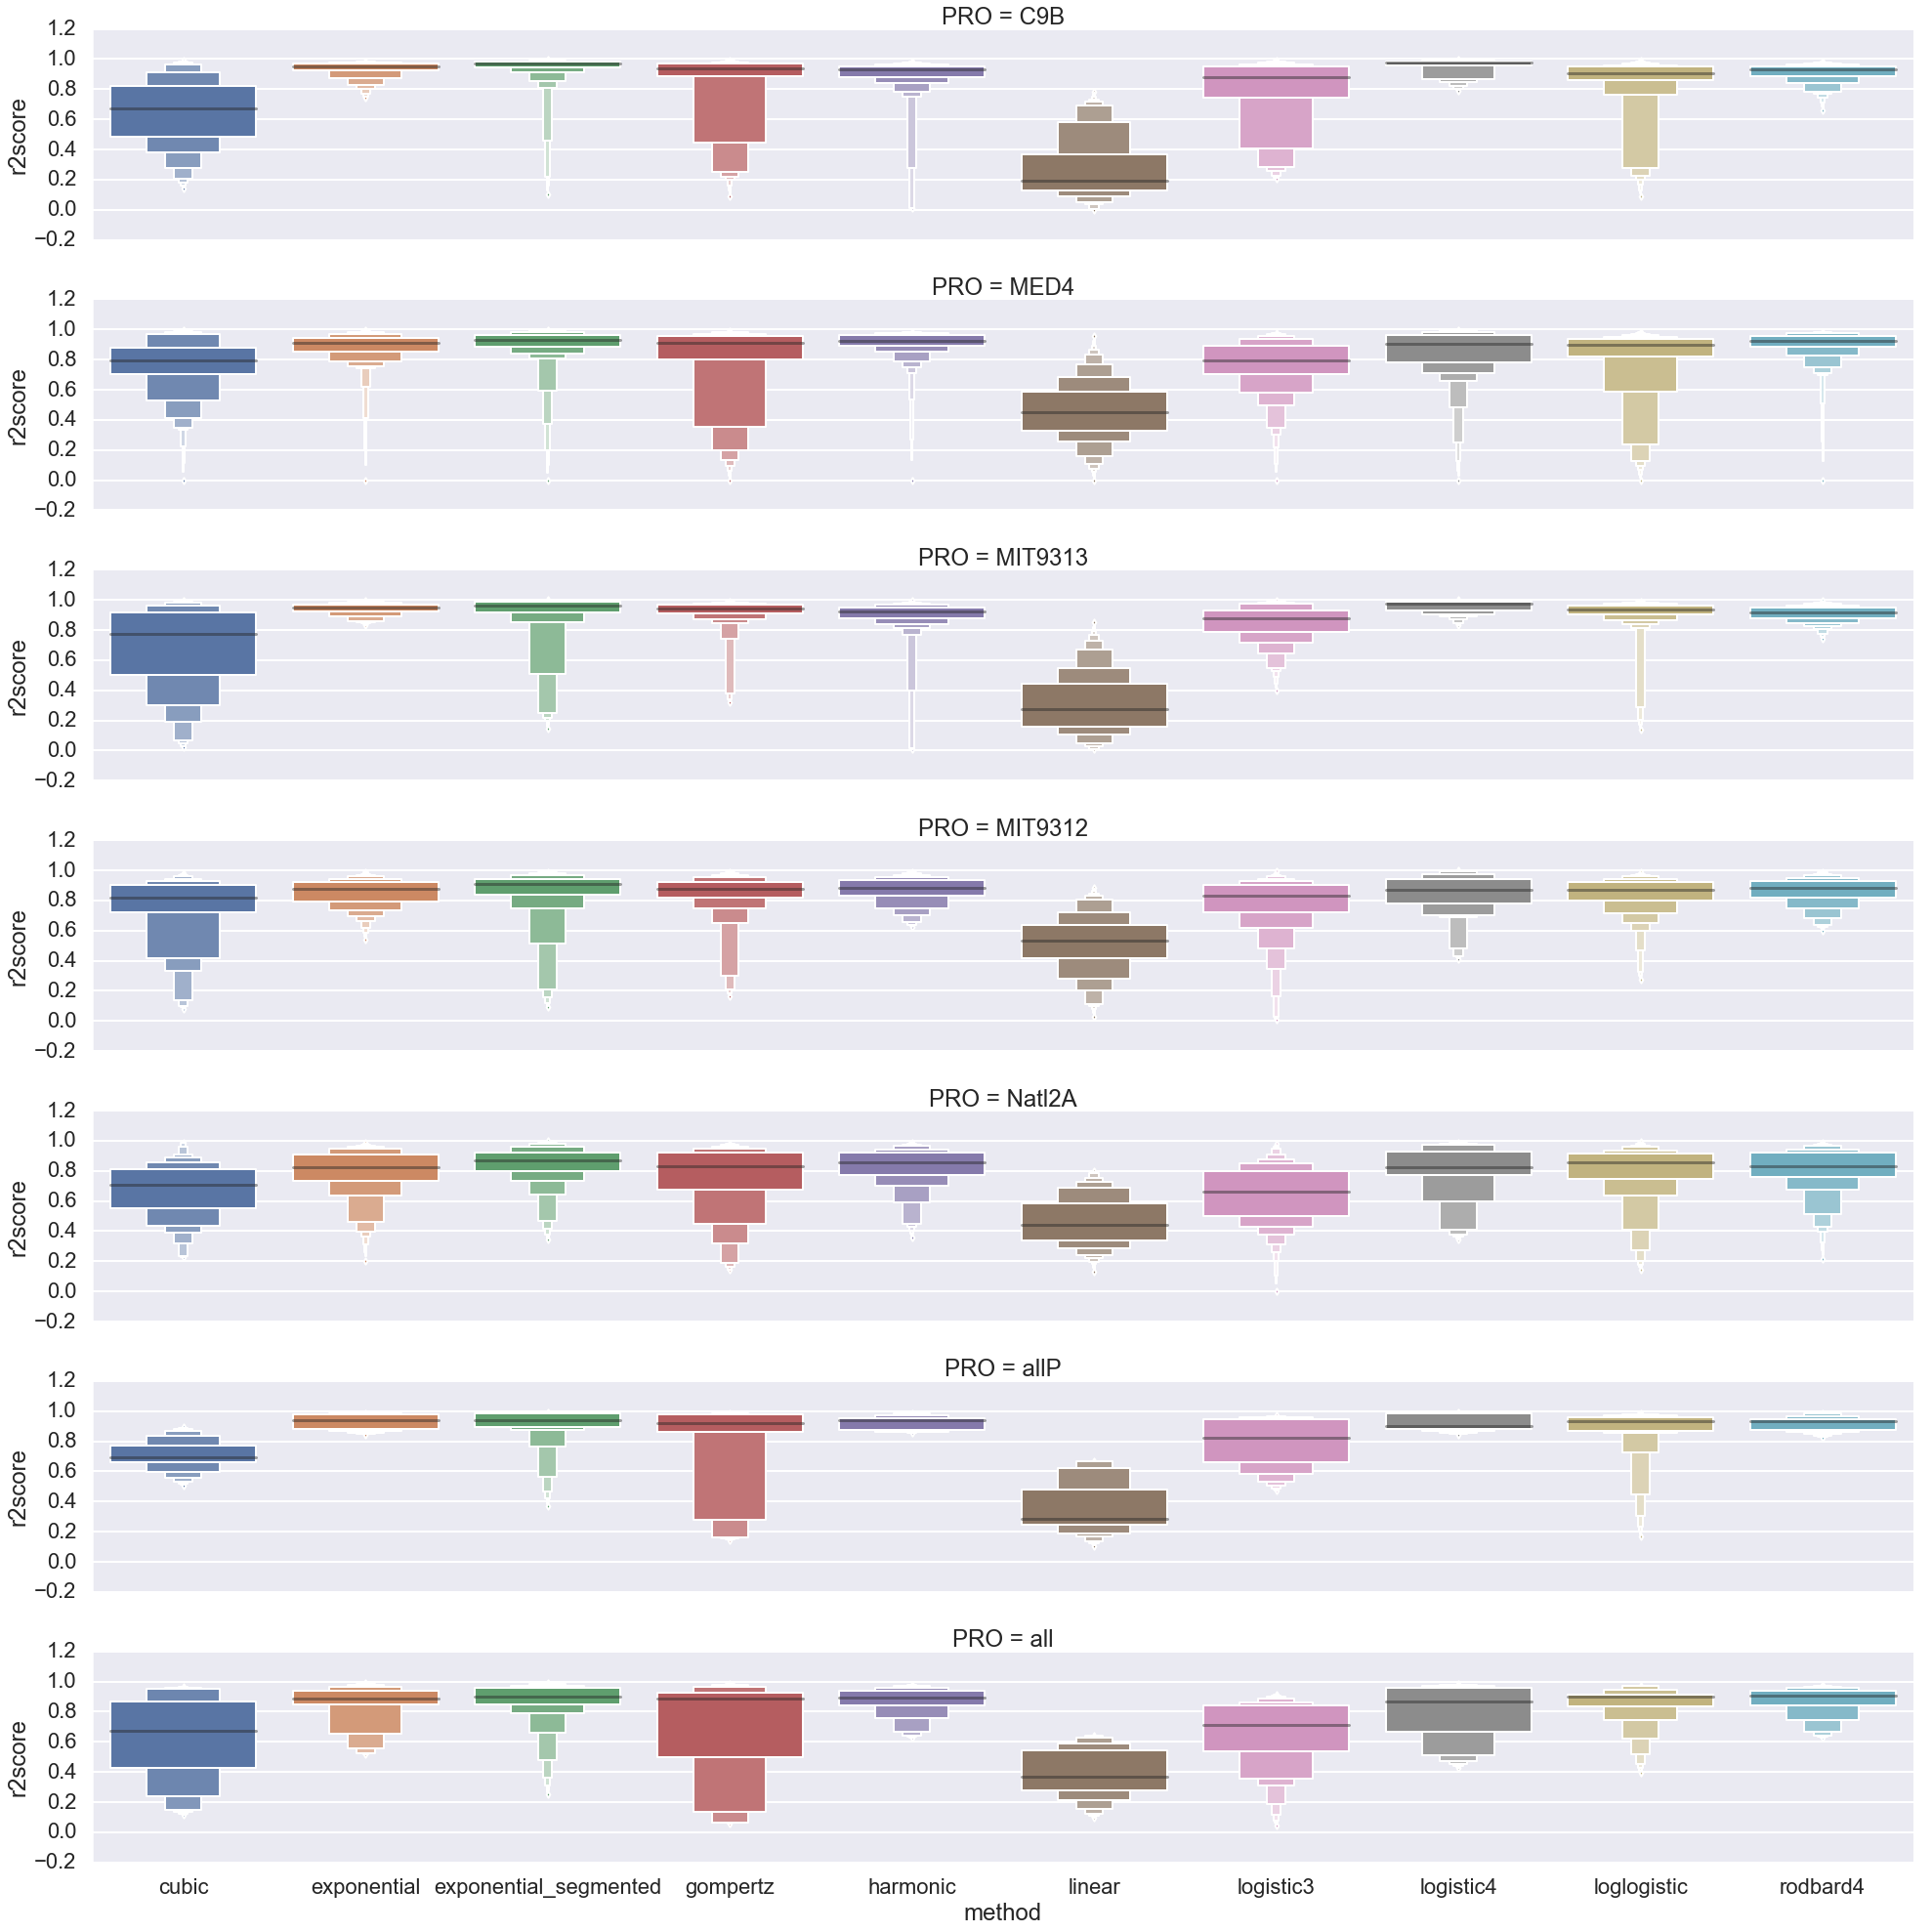

In [24]:
sns.catplot(data=scoresm, x='method', y='r2score', 
            #hue='PRO',
            kind='boxen', 
            row='PRO',
            aspect=7, height=4)


C:\Users\wosnat\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


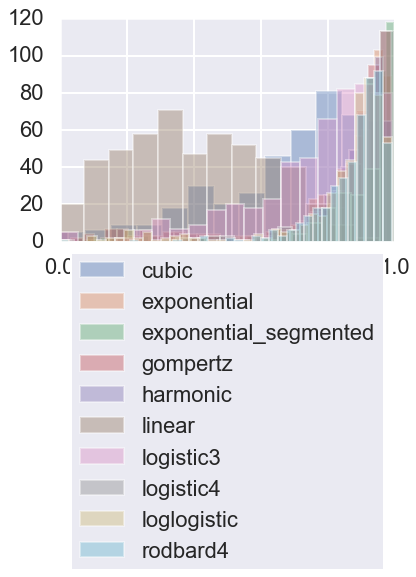

In [25]:
for i in ref_cols:
    sns.distplot(scores[i].dropna() , label=i, kde=False )
plt.legend(loc='upper right', bbox_to_anchor=(1, 0))

In [26]:
scores.max()

cubic                      0.996624
exponential                0.993721
exponential_segmented      0.999573
gompertz                   0.990522
harmonic                   0.992124
linear                     0.954468
logistic3                   0.99282
logistic4                   0.99941
loglogistic                0.992668
rodbard4                   0.992124
PRO                            allP
ALT                         all_Pro
sample                           9C
culture                  Co_Culture
experiment                       e7
dtype: object

In [28]:
scores.min()

cubic                          0
exponential                    0
exponential_segmented          0
gompertz                       0
harmonic                       0
linear                         0
logistic3                      0
logistic4                      0
loglogistic                    0
rodbard4                       0
PRO                          C9B
ALT                          1A3
sample                       10A
culture                  All_Pro
experiment                    e1
dtype: object

ValueError: Could not interpret input 'linear2'

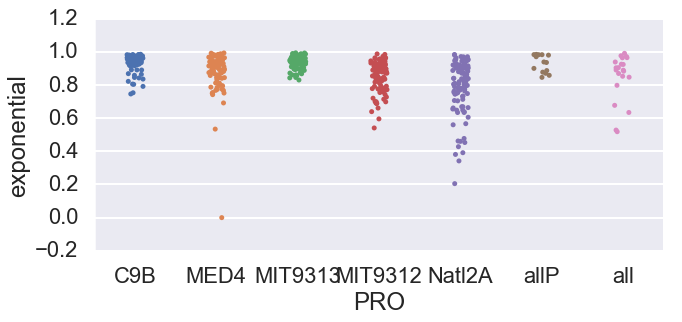

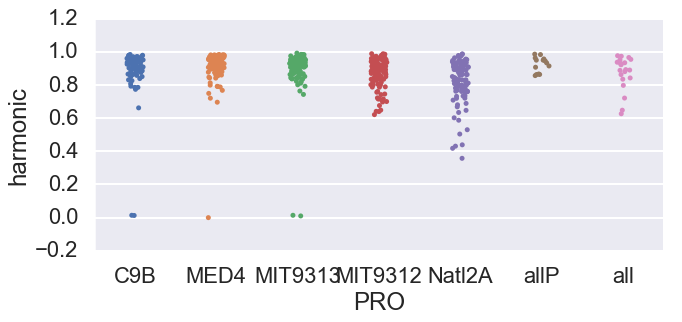

In [27]:
sns.catplot(data=scores, x='PRO', y='exponential', aspect=2)
sns.catplot(data=scores, x='PRO', y='harmonic', aspect=2)
sns.catplot(data=scores, x='PRO', y='linear2', aspect=2)

In [ ]:
sns.catplot(data=scores, x='culture', y='exponential', aspect=2)
sns.catplot(data=scores, x='culture', y='harmonic', aspect=2)
sns.catplot(data=scores, x='culture', y='linear2', aspect=2)